## Introduction

In this notebook, we will analyze data pertaining to the South Pacific ocean for evidence of sea surface temperature becoming warmer.

## Data Source

The data set that we will be using comes from ERA5. This data set contains over 80 years of daily sea surface temperature, wave height, and wind speed data.

## Import Libraries

In [671]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import median_filter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Load Data Set

Load in data set for the South Pacific ocean.

In [672]:
df = pd.read_csv("https://raw.githubusercontent.com/nguyenntina/climate-change/main/south_pacific.csv")

## Contents of Data Set

Start by exploring the contents of our data.

In [673]:
df.head()

,sst,u10,hsig,time,latitude,longitude
0,291.74900,1.479218,2.039036,1940-01-01 12:00:00,-35.0,-165.0
1,291.80466,0.636111,1.567293,1940-01-02 12:00:00,-35.0,-165.0
2,291.85544,3.894659,1.214057,1940-01-03 12:00:00,-35.0,-165.0
3,291.90817,3.991070,2.437233,1940-01-04 12:00:00,-35.0,-165.0
4,291.95996,2.706026,2.678540,1940-01-05 12:00:00,-35.0,-165.0


In [674]:
df.describe()

,sst,u10,hsig,latitude,longitude
count,30741.000000,30741.000000,30741.000000,30741.0,30741.0
mean,290.573772,0.771190,2.729200,-35.0,-165.0
std,2.337555,6.082505,0.931080,0.0,0.0
min,285.857940,-18.759240,0.940539,-35.0,-165.0
25%,288.417330,-3.833070,2.065207,-35.0,-165.0
50%,290.473970,0.715698,2.536413,-35.0,-165.0
75%,292.647000,5.290995,3.195914,-35.0,-165.0
max,298.204830,20.636452,8.566135,-35.0,-165.0


In [675]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30741 entries, 0 to 30740
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sst        30741 non-null  float64
 1   u10        30741 non-null  float64
 2   hsig       30741 non-null  float64
 3   time       30741 non-null  object 
 4   latitude   30741 non-null  float64
 5   longitude  30741 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.4+ MB


Something noticeable is that we have no null values in any columns.

## Data Type

Here we check the types we have in our data set making sure they are suitable to use.

In [676]:
df.dtypes

sst          float64
u10          float64
hsig         float64
time          object
latitude     float64
longitude    float64
dtype: object

### Data Type Conversion

In [677]:
df["time"] = pd.to_datetime(df["time"])

In [678]:
df.dtypes

sst                 float64
u10                 float64
hsig                float64
time         datetime64[ns]
latitude            float64
longitude           float64
dtype: object

Our time column had to be converted into a datetime type.

## Quick EDA

We want to perform quick exploratory data analysis to determine whether the data are sufficient to answer our question.

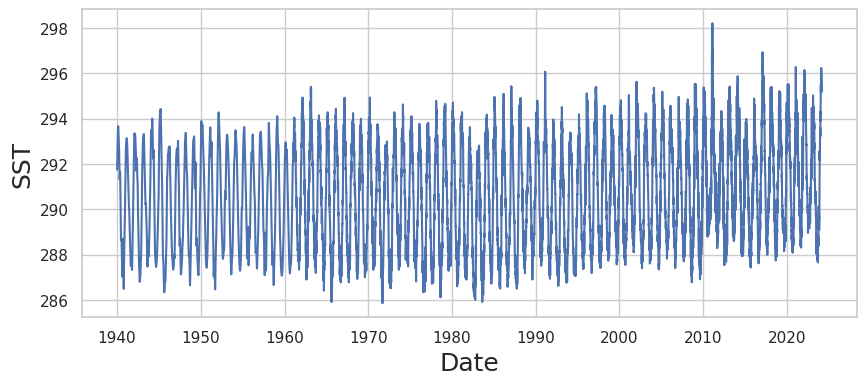

In [697]:
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='time', y='sst')
plt.xlabel('Date', fontsize=18)
plt.ylabel('SST', fontsize=18);

We observe a trend where the SST consistently begins to increase around 1990.

## Moving Average

Identify and isolate the long term warming trend through sea surface temperature using moving average.

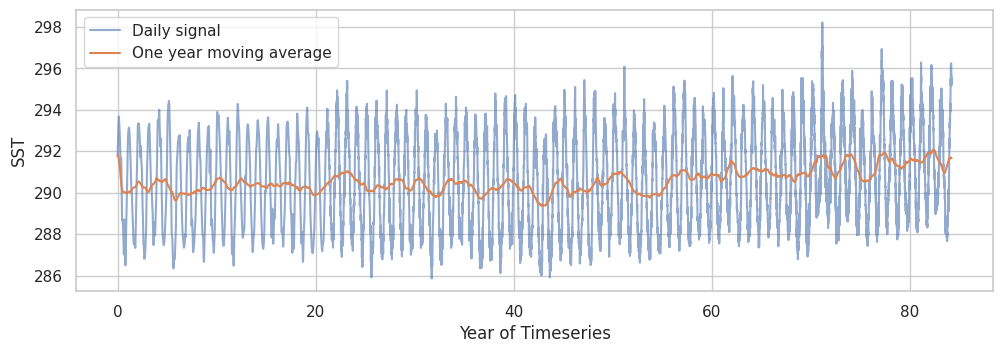

In [680]:
sst = df["sst"].values
t = np.arange(len(sst))

window_len = 365
sst_ma = uniform_filter1d(sst, size=window_len)

fig, ax = plt.subplots()

ax.plot(t / 365, sst, alpha=0.6, label="Daily signal")
ax.plot(t / 365, sst_ma, label="One year moving average")
ax.set_xlabel("Year of Timeseries")
ax.set_ylabel("SST")
ax.legend()
fig.set_size_inches(10, 3.5)
fig.tight_layout(pad=0.5)

df["sst_ma"] = sst_ma
sst_ma = df["sst_ma"].values.reshape(-1, 1)
time = df["time"].values.reshape(-1, 1)

By using moving average, we smoothed out the orange line to highlight long term trends. It is also more noticeable of an increase in SST about 50 years into our timeseries.

## Lagged Autoregression

We will now forecast our trend into the future using lagged autoregression.

In [681]:
k = 365

split_index = int(len(df) * 0.80)
train_indices = list(range(split_index))
test_indices = list(range(split_index, len(df)))

sst_ma_train = sst_ma[train_indices, :]
sst_ma_test = sst_ma[test_indices, :]

sst_ma_predictor_train = sst_ma_train[:-k, :]
sst_ma_response_train = sst_ma_train[k:, :]

sst_ma_predictor_test = sst_ma_test[:-k, :]
sst_ma_response_test = sst_ma_test[k:, :]

reg = LinearRegression().fit(sst_ma_predictor_train, sst_ma_response_train)
sst_ma_predicted = reg.predict(sst_ma_predictor_test)

mae = np.nanmean(np.abs(sst_ma_predicted - sst_ma_response_test))
rmse = np.sqrt(np.nanmean((sst_ma_predicted - sst_ma_response_test) ** 2))

start_date = df['time'].iloc[split_index + k]
last_date = df['time'].iloc[-1]
end_date = last_date + pd.DateOffset(years=20)
extended_time = pd.date_range(start=start_date, end=end_date, periods=len(time[test_indices[k:]]))

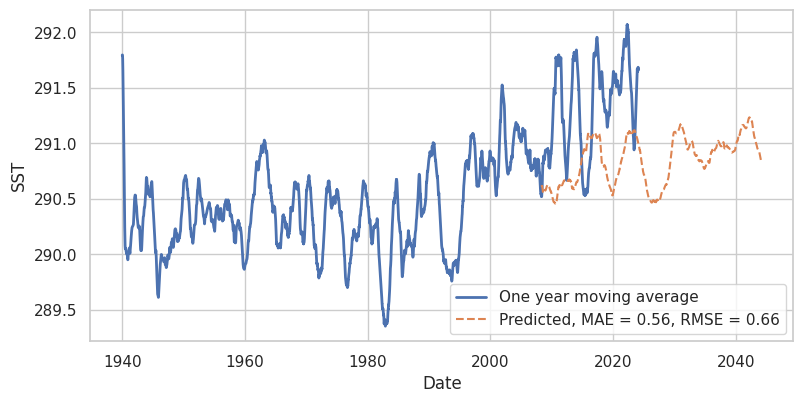

In [699]:
fig, ax = plt.subplots()
ax.plot(time, sst_ma, '-', linewidth=2, label="One year moving average")
ax.plot(extended_time, sst_ma_predicted, '--', label=f"Predicted, MAE = {mae:.2f}, RMSE = {rmse:.2f}")
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("SST")
fig.set_size_inches(8, 4)
fig.tight_layout(pad=0.5)
plt.show()

We have trained our model to predict future SST values two decades out based on the one year moving average. We see that the model shows SST increases as the years past which is similar to our original observed data.

## Additional Step

For the additional step, I will be analyzing SST averages throughout the year.

We want to see how SST varies through the four seasons.

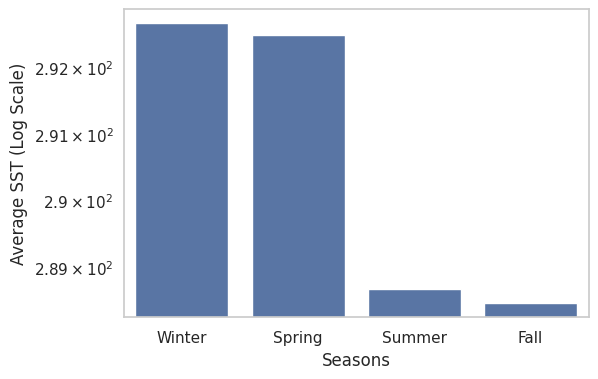

In [692]:
df['month'] = df['time'].dt.month
season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter',
              3: 'Spring', 4: 'Spring', 5: 'Spring',
              6: 'Summer', 7: 'Summer', 8: 'Summer',
              9: 'Fall', 10: 'Fall', 11: 'Fall'}

df['season'] = df['month'].map(season_map)
seasonal_avg_sst = df.groupby('season')['sst'].mean().reindex(['Winter', 'Spring', 'Summer', 'Fall']).reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='season', y='sst', data=seasonal_avg_sst)
plt.yscale('log')
plt.xlabel('Seasons')
plt.ylabel('Average SST (Log Scale)');

Using a log scale allows us to better see the range of data values. The winter season seems to have the warmest SST out of all the seasons. This make sense since the South Pacific Ocean is located in the Southern hemisphere where they experience their summer in the Winter months.

To further drill down, we can also look at the individual months.

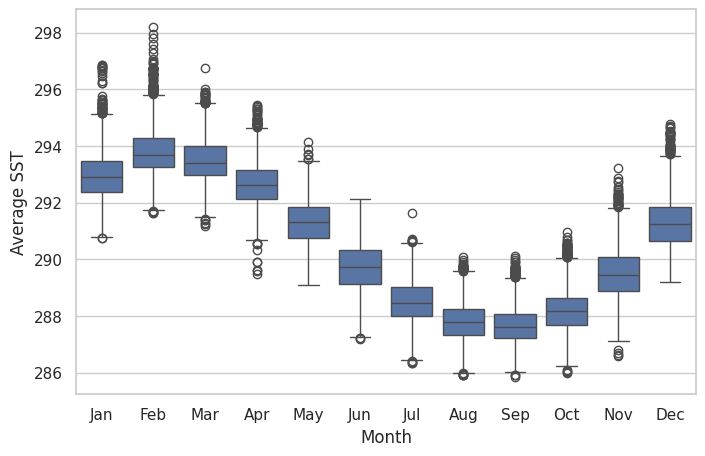

In [694]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='month', y='sst', data= df)
plt.xlabel('Month')
plt.ylabel('Average SST')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

This analysis provides insights into the patterns of SST changes throughout the year. The month with the warmest average SST is February. We see a gradual decrease from March to August. We also observe a lot of outliers in the months of January, February, and December.